---
---

## Imports


In [38]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

print("✅ Configuration Set. NOW RESTART THE SESSION!")


✅ Configuration Set. NOW RESTART THE SESSION!


In [39]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import sys
import re
import math
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Activation, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(f"TensorFlow Version: {tf.__version__}")
gpus = get_available_gpus()

if len(gpus) > 0:
    print(f"✅ GPU DETECTED: {gpus}")
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = False
    sess = tf.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess) 
    print("✅ GPU Session Configured Successfully!")
else:
    print("❌ NO GPU DETECTED. Check Kaggle Settings.")


TensorFlow Version: 2.19.0
✅ GPU DETECTED: ['/device:GPU:0']
✅ GPU Session Configured Successfully!


I0000 00:00:1767903418.481954      55 gpu_device.cc:2019] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1767903418.483259      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Set Random Seed for Reproducibility

Setting random seeds ensures that results are reproducible across different runs.


In [40]:
# Set random seeds for reproducibility
import random

SEED = 42  # You can change this to any integer

# Set Python's built-in random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set TensorFlow random seed (TF 1.x style)
tf.set_random_seed(SEED)

# For TF 2.x compatibility (if needed)
try:
    tf.random.set_seed(SEED)
except:
    pass

# Set Python hash seed for reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"✅ Random seed set to {SEED} for reproducibility")
print("   - Python random: set")
print("   - NumPy random: set")
print("   - TensorFlow random: set")
print("   - Python hash seed: set")


✅ Random seed set to 42 for reproducibility
   - Python random: set
   - NumPy random: set
   - TensorFlow random: set
   - Python hash seed: set


In [41]:
# Verify imports are working
print("Library Versions:")
print(f"  NumPy      : {np.__version__}")
print(f"  Pandas     : {pd.__version__}")
print(f"  Matplotlib : {plt.matplotlib.__version__}")
print(f"  Seaborn    : {sns.__version__}")


Library Versions:
  NumPy      : 2.0.2
  Pandas     : 2.2.2
  Matplotlib : 3.10.0
  Seaborn    : 0.13.2


---

## GPU Setup


In [42]:
print(f"TensorFlow Version: {tf.__version__} (Running in 1.x mode)")

try:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # Don't grab all GPU memory at once
    config.log_device_placement = False
    sess = tf.Session(config=config)
    K.set_session(sess)
    print("✅ GPU configured successfully")
except Exception as e:
    print(f"⚠️ GPU Setup Warning: {e}")


TensorFlow Version: 2.19.0 (Running in 1.x mode)
⚠️ GPU Setup Warning: module 'tensorflow.keras.backend' has no attribute 'set_session'


I0000 00:00:1767903418.539726      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [43]:
# Verify GPU is available
from tensorflow.python.client import device_lib
local_devices = device_lib.list_local_devices()
print("Available devices:")
for device in local_devices:
    print(f"  {device.device_type}: {device.name}")


Available devices:
  CPU: /device:CPU:0
  GPU: /device:GPU:0


I0000 00:00:1767903418.555621      55 gpu_device.cc:2019] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


---

## Parameters


In [44]:
BATCH_SIZE = 512       
EPOCHS = 30            
LATENT_DIM = 512       
EMBEDDING_DIM = 512     
MAX_SAMPLES = 100000   
MAX_SEQ_LEN = 120       
BEAM_WIDTH = 5         
print("Hyperparameters set:")
print(f"  BATCH_SIZE    = {BATCH_SIZE}")
print(f"  EPOCHS        = {EPOCHS}")
print(f"  LATENT_DIM    = {LATENT_DIM}")
print(f"  EMBEDDING_DIM = {EMBEDDING_DIM}")
print(f"  MAX_SAMPLES   = {MAX_SAMPLES}")
print(f"  MAX_SEQ_LEN   = {MAX_SEQ_LEN}")
print(f"  BEAM_WIDTH    = {BEAM_WIDTH}")


Hyperparameters set:
  BATCH_SIZE    = 512
  EPOCHS        = 30
  LATENT_DIM    = 512
  EMBEDDING_DIM = 512
  MAX_SAMPLES   = 100000
  MAX_SEQ_LEN   = 120
  BEAM_WIDTH    = 5


---

### Visualize Parameters


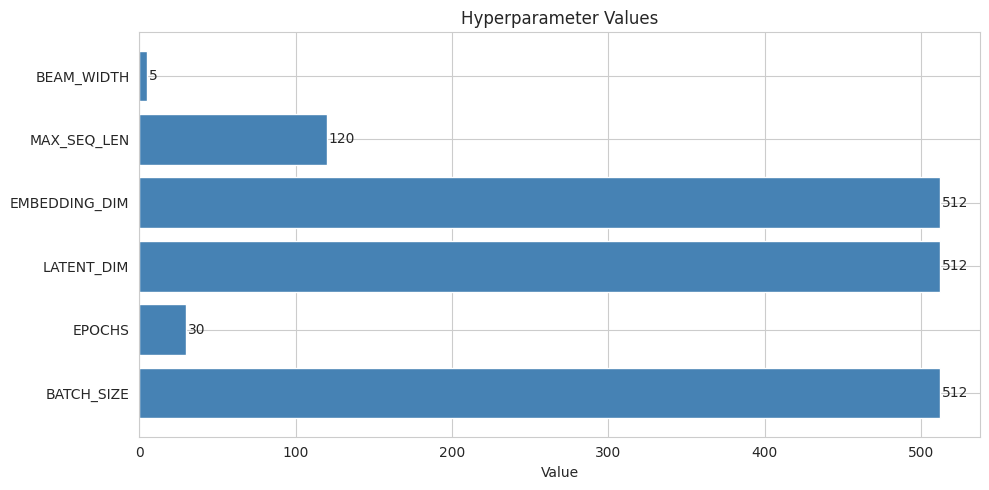

In [45]:
hyperparams = {
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LATENT_DIM': LATENT_DIM,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'MAX_SEQ_LEN': MAX_SEQ_LEN,
    'BEAM_WIDTH': BEAM_WIDTH
}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(list(hyperparams.keys()), list(hyperparams.values()), color='steelblue')
ax.set_xlabel('Value')
ax.set_title('Hyperparameter Values')
for bar, val in zip(bars, hyperparams.values()):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(val), va='center')
plt.tight_layout()
plt.show()


---

## Load Data

Loads `train.csv`, `val.csv`, and `test.csv`.


In [46]:
def load_data(path, num_samples=None):
    """Load CSV and return (inputs, targets) with start/end tokens."""
    if not os.path.exists(path):
        print(f"⚠️ File not found: {path}")
        return [], []
    df = pd.read_csv(path)
    if num_samples:
        df = df.iloc[:num_samples]
    df = df.dropna()
    inputs = df['augmented_text'].astype(str).tolist()
    targets = ['\t' + txt + '\n' for txt in df['text'].astype(str).tolist()]
    return inputs, targets

print("load_data() function defined.")


load_data() function defined.


In [47]:
train_input_texts, train_target_texts = load_data('/kaggle/input/spellcheck/train.csv', MAX_SAMPLES)
val_input_texts, val_target_texts = load_data('/kaggle/input/spellcheck/val.csv', 10000)
test_input_texts, test_target_texts = load_data('/kaggle/input/spellcheck/test.csv', 100)

if len(train_input_texts) == 0:
    print("⚠️ No training data found. Check that CSVs are in the same folder.")
else:
    print(f"✅ Training samples : {len(train_input_texts)}")
    print(f"✅ Validation samples: {len(val_input_texts)}")
    print(f"✅ Test samples      : {len(test_input_texts)}")


✅ Training samples : 100000
✅ Validation samples: 10000
✅ Test samples      : 100


---

### Visualize Dataset Sizes


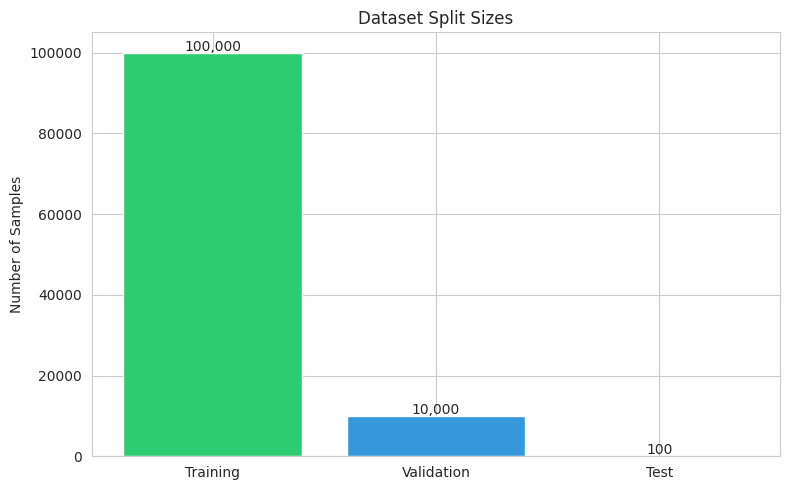

In [48]:
dataset_sizes = {
    'Training': len(train_input_texts),
    'Validation': len(val_input_texts),
    'Test': len(test_input_texts)
}

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(dataset_sizes.keys(), dataset_sizes.values(), color=colors)
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Split Sizes')
for bar, val in zip(bars, dataset_sizes.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{val:,}', ha='center')
plt.tight_layout()
plt.show()


In [49]:
print("Sample data (first 3):")
for i in range(min(3, len(train_input_texts))):
    print(f"  Input : {train_input_texts[i]}")
    print(f"  Target: {train_target_texts[i].strip()}")
    print()


Sample data (first 3):
  Input : barbaric and shocking use of ofcre agaistn
  Target: barbaric and shocking use of force against

  Input : pm assy energy policy has laomst universal support
  Target: pm says energy policy has almost universal support

  Input : coronavirus tasmania peter gutwein econIjy JJpact
  Target: coronavirus tasmania peter gutwein economy impact



---

### Visualize Sample Length Distribution


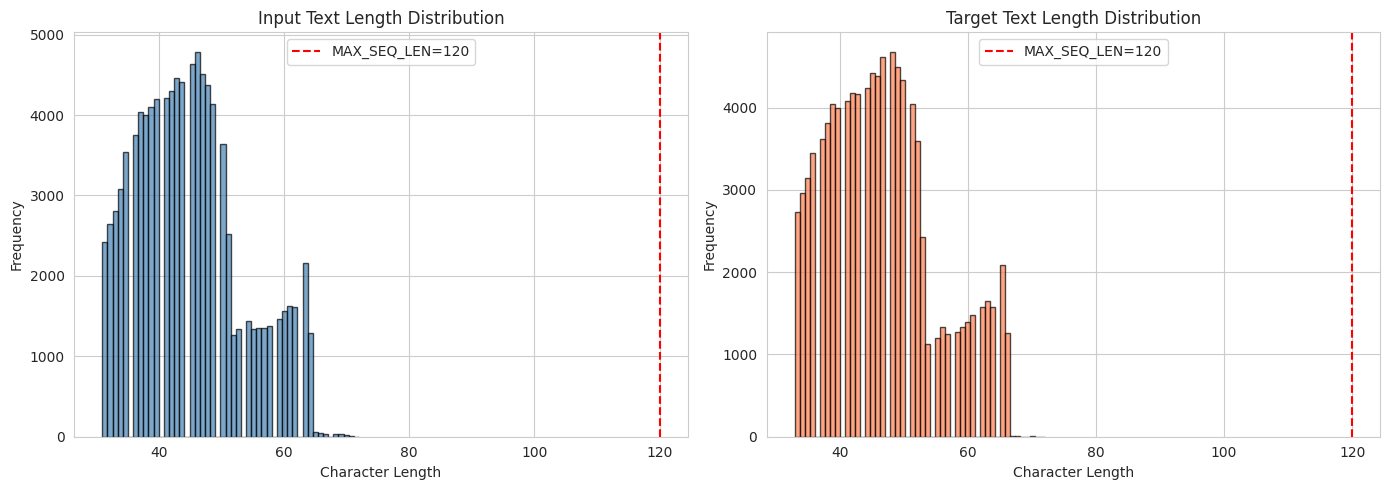

Input lengths  - Mean: 44.8, Max: 72, Min: 31
Target lengths - Mean: 46.5, Max: 72, Min: 33
Samples exceeding MAX_SEQ_LEN (120): 0


In [50]:
input_lengths = [len(txt) for txt in train_input_texts]
target_lengths = [len(txt) for txt in train_target_texts]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(input_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=MAX_SEQ_LEN, color='red', linestyle='--', label=f'MAX_SEQ_LEN={MAX_SEQ_LEN}')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Input Text Length Distribution')
axes[0].legend()

axes[1].hist(target_lengths, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(x=MAX_SEQ_LEN, color='red', linestyle='--', label=f'MAX_SEQ_LEN={MAX_SEQ_LEN}')
axes[1].set_xlabel('Character Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Target Text Length Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Input lengths  - Mean: {np.mean(input_lengths):.1f}, Max: {np.max(input_lengths)}, Min: {np.min(input_lengths)}")
print(f"Target lengths - Mean: {np.mean(target_lengths):.1f}, Max: {np.max(target_lengths)}, Min: {np.min(target_lengths)}")
print(f"Samples exceeding MAX_SEQ_LEN ({MAX_SEQ_LEN}): {sum(1 for l in input_lengths if l > MAX_SEQ_LEN)}")


---

## Tokenization


In [51]:
tokenizer = Tokenizer(char_level=True, filters='')  # 
tokenizer.fit_on_texts(train_input_texts + train_target_texts + val_input_texts + val_target_texts)

vocab_size = len(tokenizer.word_index) + 1  
reverse_char_map = {i: char for char, i in tokenizer.word_index.items()}
target_token_index = tokenizer.word_index

print(f"✅ Vocabulary size: {vocab_size}")
print(f"   Sample char→index: {dict(list(tokenizer.word_index.items())[:10])}")


✅ Vocabulary size: 61
   Sample char→index: {' ': 1, 'e': 2, 'a': 3, 's': 4, 'r': 5, 'o': 6, 'i': 7, 't': 8, 'n': 9, 'l': 10}


---

### Visualize Character Vocabulary


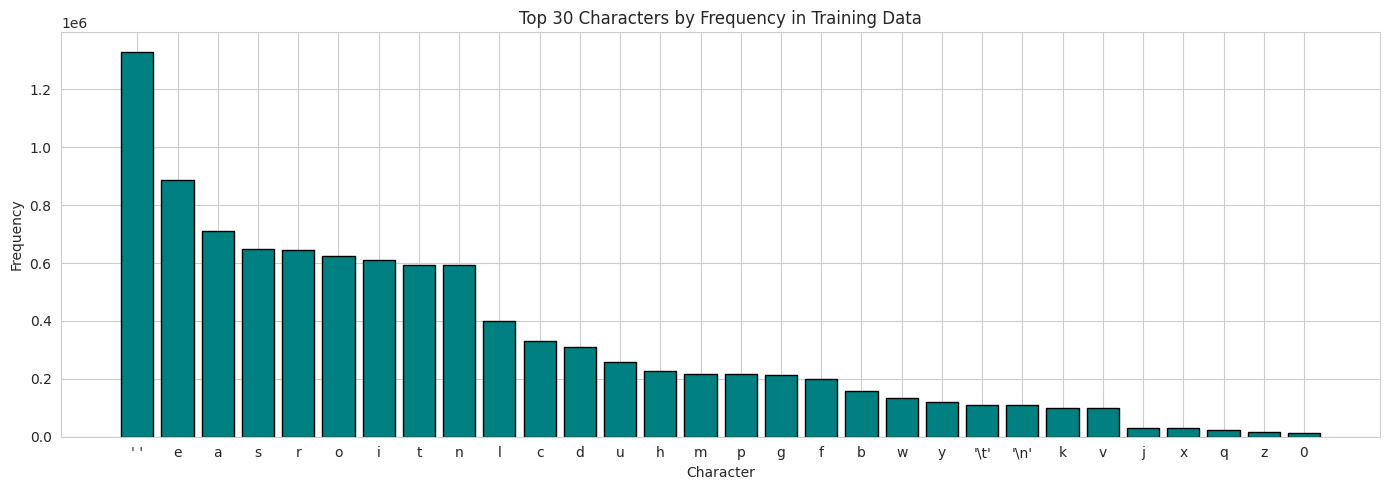

Total unique characters in vocabulary: 60


In [52]:
char_counts = tokenizer.word_counts
sorted_chars = sorted(char_counts.items(), key=lambda x: x[1], reverse=True)[:30]

chars = [c[0] if c[0] not in ['\t', '\n', ' '] else repr(c[0]) for c in sorted_chars]
counts = [c[1] for c in sorted_chars]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(chars, counts, color='teal', edgecolor='black')
ax.set_xlabel('Character')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Characters by Frequency in Training Data')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Total unique characters in vocabulary: {vocab_size - 1}")


---

## Preprocessing


In [53]:
def preprocess_data(input_texts, target_texts):
    """Convert text lists to padded sequences for encoder and decoder."""
    encoder_seq = tokenizer.texts_to_sequences(input_texts)
    encoder_pad = pad_sequences(encoder_seq, maxlen=MAX_SEQ_LEN, padding='post')
    
    decoder_seq = tokenizer.texts_to_sequences(target_texts)
    decoder_pad = pad_sequences(decoder_seq, maxlen=MAX_SEQ_LEN, padding='post')
    
    target_seqs = [seq[1:] for seq in decoder_seq]
    target_pad = pad_sequences(target_seqs, maxlen=MAX_SEQ_LEN, padding='post')
    target_pad = np.expand_dims(target_pad, -1)  
    
    return encoder_pad, decoder_pad, target_pad

print("preprocess_data() function defined.")


preprocess_data() function defined.


In [54]:
train_enc, train_dec, train_target = preprocess_data(train_input_texts, train_target_texts)
val_enc, val_dec, val_target = preprocess_data(val_input_texts, val_target_texts)

print(f"✅ Training data shapes:")
print(f"   Encoder input : {train_enc.shape}")
print(f"   Decoder input : {train_dec.shape}")
print(f"   Decoder target: {train_target.shape}")


✅ Training data shapes:
   Encoder input : (100000, 120)
   Decoder input : (100000, 120)
   Decoder target: (100000, 120, 1)


---

### Visualize Preprocessed Data Shapes


In [55]:
shapes_data = {
    'Array': ['train_enc', 'train_dec', 'train_target', 'val_enc', 'val_dec', 'val_target'],
    'Shape': [str(train_enc.shape), str(train_dec.shape), str(train_target.shape),
              str(val_enc.shape), str(val_dec.shape), str(val_target.shape)],
    'Description': ['Encoder input (train)', 'Decoder input (train)', 'Decoder target (train)',
                    'Encoder input (val)', 'Decoder input (val)', 'Decoder target (val)']
}
shapes_df = pd.DataFrame(shapes_data)
print("Preprocessed Data Shapes:")
print(shapes_df.to_string(index=False))


Preprocessed Data Shapes:
       Array            Shape            Description
   train_enc    (100000, 120)  Encoder input (train)
   train_dec    (100000, 120)  Decoder input (train)
train_target (100000, 120, 1) Decoder target (train)
     val_enc     (10000, 120)    Encoder input (val)
     val_dec     (10000, 120)    Decoder input (val)
  val_target  (10000, 120, 1)   Decoder target (val)


In [56]:
sample_idx = 0
print(f"Sample {sample_idx} visualization:")
print(f"  Original input : {train_input_texts[sample_idx]}")
print(f"  Encoded (first 20): {train_enc[sample_idx][:20]}")
print(f"  Original target: {train_target_texts[sample_idx].strip()}")
print(f"  Encoded (first 20): {train_dec[sample_idx][:20]}")


Sample 0 visualization:
  Original input : barbaric and shocking use of ofcre agaistn
  Encoded (first 20): [19  3  5 19  3  5  7 11  1  3  9 12  1  4 14  6 11 24  7  9]
  Original target: barbaric and shocking use of force against
  Encoded (first 20): [22 19  3  5 19  3  5  7 11  1  3  9 12  1  4 14  6 11 24  7]


---

## Build Model (Seq2Seq with Attention)

**Encoder**: Bidirectional LSTM reads noisy input

**Decoder**: LSTM generates corrected output

**Attention**: Helps decoder focus on relevant encoder positions


In [57]:
def manual_attention(query, value):
    """Dot-product attention mechanism."""
    score = Dot(axes=[2, 2])([query, value])       
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, value])  
    return context_vector

print("manual_attention() function defined.")


manual_attention() function defined.


In [58]:
# --- ENCODER ---
encoder_inputs = Input(shape=(MAX_SEQ_LEN,), name='encoder_inputs')
enc_emb = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, mask_zero=True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

print("✅ Encoder built")
print(f"   Encoder output shape: {encoder_outputs.shape}")
print(f"   State h shape: {state_h.shape}")


✅ Encoder built
   Encoder output shape: (?, 120, 1024)
   State h shape: (?, 1024)


In [59]:
# --- DECODER ---
decoder_inputs = Input(shape=(MAX_SEQ_LEN,), name='decoder_inputs')
dec_emb_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM * 2, return_sequences=True, return_state=True)  
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

print("✅ Decoder built")
print(f"   Decoder output shape: {decoder_outputs.shape}")


✅ Decoder built
   Decoder output shape: (?, 120, 1024)


In [60]:
# --- ATTENTION + OUTPUT ---
attention_result = manual_attention(decoder_outputs, encoder_outputs)
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_result])

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

print("✅ Attention and output layer built")
print(f"   Final output shape: {decoder_outputs.shape}")


✅ Attention and output layer built
   Final output shape: (?, 120, 61)


In [61]:
# --- COMPILE MODEL ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("✅ Model compiled")
model.summary()


✅ Model compiled
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 120)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding_2 (Embedding)     (None, 120, 512)             31232     ['encoder_inputs[0][0]']      
                                                                                                  
 decoder_inputs (InputLayer  [(None, 120)]                0         []                            
 )                                                                                                
                                                                           

---

### Visualize Model Architecture Summary


Model Parameter Summary:
  Total parameters     : 10,681,405
  Trainable parameters : 10,681,405
  Non-trainable params : 0


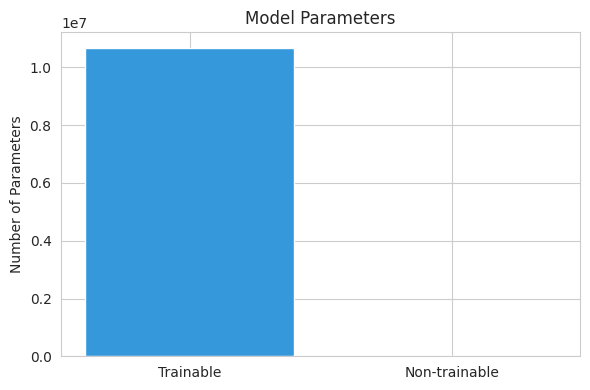

In [62]:
# Count model parameters
total_params = model.count_params()
trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("Model Parameter Summary:")
print(f"  Total parameters     : {total_params:,}")
print(f"  Trainable parameters : {trainable_params:,}")
print(f"  Non-trainable params : {non_trainable_params:,}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Trainable', 'Non-trainable'], [trainable_params, non_trainable_params], color=['#3498db', '#95a5a6'])
ax.set_ylabel('Number of Parameters')
ax.set_title('Model Parameters')
plt.tight_layout()
plt.show()


---

## Training


In [63]:
# Callbacks
checkpoint = ModelCheckpoint(
    "best_speller_pro.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("✅ Callbacks ready (checkpoint + early stopping)")


✅ Callbacks ready (checkpoint + early stopping)


In [64]:
history = model.fit(
    [train_enc, train_dec],
    train_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_enc, val_dec], val_target),
    callbacks=[checkpoint, early_stopping]
)

print("\n✅ Training complete!")
print(f"   Best model saved to: best_speller_pro.h5")


Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - ETA: 0s - loss: 2.1586 - acc: 0.3859

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training_v1.py:2330: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.49978, saving model to best_speller_pro.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100000/100000 [==============================] - 183s 2ms/sample - loss: 2.1586 - acc: 0.3859 - val_loss: 0.4998 - val_acc: 0.8763
Epoch 2/30
100000/100000 [==============================] - ETA: 0s - loss: 0.3723 - acc: 0.9001
Epoch 2: val_loss improved from 0.49978 to 0.26023, saving model to best_speller_pro.h5
100000/100000 [==============================] - 180s 2ms/sample - loss: 0.3723 - acc: 0.9001 - val_loss: 0.2602 - val_acc: 0.9276
Epoch 3/30
100000/100000 [==============================] - ETA: 0s - loss: 0.2242 - acc: 0.9369
Epoch 3: val_loss improved from 0.26023 to 0.18943, saving model to best_speller_pro.h5
100000/100000 [==============================] - 180s 2ms/sample - loss: 0.2242 - acc: 0.9369 - val_loss: 0.1894 - val_acc: 0.9459
Epoch 4/30
100000/100000 [==============================] - ETA: 0s - loss: 0.1618 - acc: 0.9533
Epoch 4: val_loss improved from 0.18943 to 0.15334, saving model to best_speller_pro.h5
100000/100000 [==============================] - 180

---

### Visualize Training Progress for Loss and Accuracy


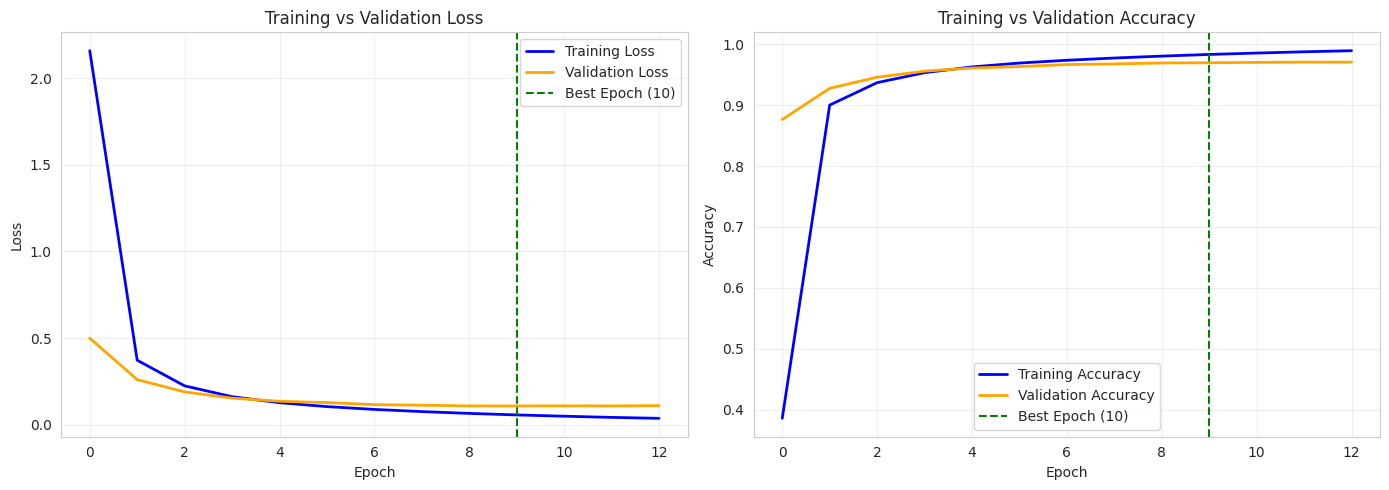

In [65]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
best_epoch = np.argmin(history.history['val_loss'])
axes[0].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['acc'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history.history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [66]:
import pandas as pd
import numpy as np

# Training metrics summary table
epochs_run = len(history.history['loss'])
metrics_data = {
    'Metric': ['Final Train Loss', 'Final Val Loss', 'Final Train Acc', 'Final Val Acc', 
               'Best Val Loss', 'Best Epoch', 'Epochs Run'],
    'Value': [
        f"{history.history['loss'][-1]:.4f}",
        f"{history.history['val_loss'][-1]:.4f}",
        f"{history.history['acc'][-1]:.4f}",       
        f"{history.history['val_acc'][-1]:.4f}",   
        f"{min(history.history['val_loss']):.4f}",
        f"{np.argmin(history.history['val_loss']) + 1}",
        f"{epochs_run}"
    ]
}
metrics_df = pd.DataFrame(metrics_data)
print("Training Metrics Summary:")
print(metrics_df.to_string(index=False))


Training Metrics Summary:
          Metric  Value
Final Train Loss 0.0367
  Final Val Loss 0.1100
 Final Train Acc 0.9894
   Final Val Acc 0.9706
   Best Val Loss 0.1081
      Best Epoch     10
      Epochs Run     13


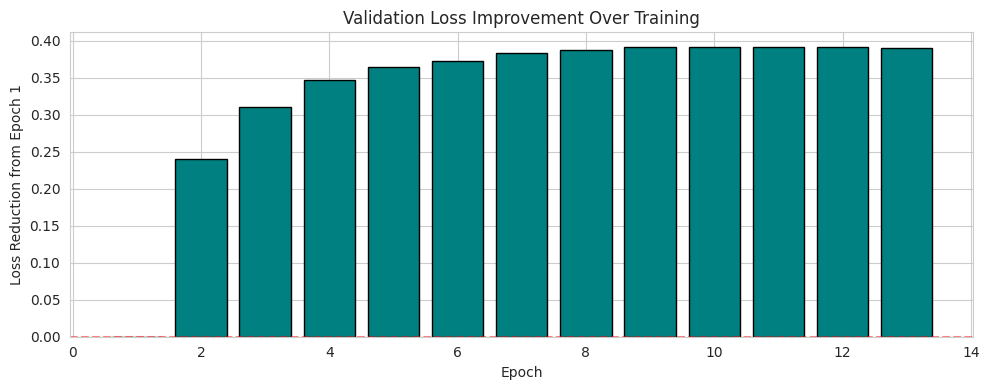

In [67]:
# Visualize improvement over epochs
improvement = [history.history['val_loss'][0] - v for v in history.history['val_loss']]

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(1, len(improvement) + 1), improvement, color='teal', edgecolor='black')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Reduction from Epoch 1')
ax.set_title('Validation Loss Improvement Over Training')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


---

## Training History Loss Curves


In [68]:
import numpy as np

# Print training history
print("Training History:")
print(f"  Final train loss: {history.history['loss'][-1]:.4f}")
print(f"  Final val loss  : {history.history['val_loss'][-1]:.4f}")
print(f"  Final train acc : {history.history['acc'][-1]:.4f}")
print(f"  Final val acc   : {history.history['val_acc'][-1]:.4f}")
print(f"  Best epoch      : {np.argmin(history.history['val_loss']) + 1}")


Training History:
  Final train loss: 0.0367
  Final val loss  : 0.1100
  Final train acc : 0.9894
  Final val acc   : 0.9706
  Best epoch      : 10


---

## Build Inference Models


In [69]:
encoder_model_inf = Model(encoder_inputs, [encoder_outputs] + encoder_states)

print("✅ Encoder inference model built")


✅ Encoder inference model built


In [70]:
# --- DECODER INFERENCE MODEL ---
decoder_state_input_h = Input(shape=(LATENT_DIM * 2,))
decoder_state_input_c = Input(shape=(LATENT_DIM * 2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_inf = Input(shape=(1,))  
dec_emb_inf = dec_emb_layer(decoder_inputs_inf)

decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(dec_emb_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]

encoder_outputs_input = Input(shape=(MAX_SEQ_LEN, LATENT_DIM * 2))
attention_result_inf = manual_attention(decoder_outputs_inf, encoder_outputs_input)
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_result_inf])
decoder_outputs_inf = decoder_dense(decoder_concat_inf)

decoder_model_inf = Model(
    [decoder_inputs_inf, decoder_state_input_h, decoder_state_input_c, encoder_outputs_input],
    [decoder_outputs_inf] + decoder_states_inf
)

print("✅ Decoder inference model built")


✅ Decoder inference model built


---

## Helper Functions for Inference


In [71]:
def restore_numbers(original_text, pred_text):
    """
    Keep numbers from original text stable.
    Prevents '3600' from becoming '3500'.
    """
    input_nums = re.findall(r'\d+', original_text)
    pred_nums = re.findall(r'\d+', pred_text)
    
    if len(input_nums) > 0 and len(input_nums) == len(pred_nums):
        for i in range(len(input_nums)):
            pred_text = pred_text.replace(pred_nums[i], input_nums[i], 1)
    return pred_text

print("restore_numbers() function defined.")


restore_numbers() function defined.


In [72]:
def beam_search_decode(input_text, k=BEAM_WIDTH):
    """
    Beam search decoding: explores top-k candidates at each step.
    Returns the most likely corrected text.
    """
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_pad = pad_sequences(input_seq, maxlen=MAX_SEQ_LEN, padding='post')
    
    # Encode input
    enc_outs, h, c = encoder_model_inf.predict(input_pad)
    
    
    start_token = target_token_index['\t']
    beams = [[0.0, "", start_token, h, c]]
    
    for _ in range(MAX_SEQ_LEN):
        all_candidates = []
        
        for b in beams:
            score, seq, last_tok, st_h, st_c = b
            
            
            if len(seq) > 0 and seq[-1] == '\n':
                all_candidates.append(b)
                continue
            
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = last_tok
            
            
            probs, new_h, new_c = decoder_model_inf.predict([target_seq, st_h, st_c, enc_outs])
            probs = probs[0, -1, :]
            
            
            top_indices = np.argsort(probs)[-k:]
            
            for idx in top_indices:
                p = probs[idx]
                if p < 1e-10:
                    continue
                new_score = score + math.log(p)
                char = reverse_char_map.get(idx, '')
                new_seq = seq + char
                all_candidates.append([new_score, new_seq, idx, new_h, new_c])
        
        
        beams = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:k]
        
        
        if all(b[1].endswith('\n') for b in beams):
            break
    
    best_seq = beams[0][1].strip()
    final_seq = restore_numbers(input_text, best_seq)
    return final_seq

print("beam_search_decode() function defined.")


beam_search_decode() function defined.


---

## Test Predictions


In [73]:
print(f"Testing with Beam Search (Width={BEAM_WIDTH})\n")
print("=" * 60)

for i in range(min(5, len(test_input_texts))):
    input_txt = test_input_texts[i]
    correct_txt = test_target_texts[i].strip()
    
    try:
        pred_txt = beam_search_decode(input_txt)
        
        print(f"Input   : {input_txt}")
        print(f"Predicted: {pred_txt}")
        print(f"Correct : {correct_txt}")
        print(f"Match   : {'✅' if pred_txt == correct_txt else '❌'}")
        print("-" * 60)
    except Exception as e:
        print(f"Error on sample {i}: {e}")


Testing with Beam Search (Width=5)



/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training_v1.py:2354: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Input   : project looks to muelsnig ngeetic alternative
Predicted: project looks to mulesing genetic alternative
Correct : project looks to mulesing genetic alternative
Match   : ✅
------------------------------------------------------------
Input   : chemical agents used during LrotWst at port ahgusra prixoj
Predicted: chemical agents used during protest at port angustra prixon
Correct : chemical agents used during protest at port augusta prison
Match   : ❌
------------------------------------------------------------
Input   : business hcmaber seeks budget infrastrcutuer boost
Predicted: business chamber seeks budget infrastructure boost
Correct : business chamber seeks budget infrastructure boost
Match   : ✅
------------------------------------------------------------
Input   : 3600 trips made to adrwni tip after cyconle
Predicted: 3600 trips made to darwin tip after cyclone
Correct : 3600 trips made to darwin tip after cyclone
Match   : ✅
--------------------------------------------

---

### Visualize Test Results


In [74]:
# Run evaluation on more test samples and calculate metrics
num_test = min(20, len(test_input_texts))
results = []

print("Running evaluation on test samples...")
for i in range(num_test):
    input_txt = test_input_texts[i]
    correct_txt = test_target_texts[i].strip()
    
    try:
        pred_txt = beam_search_decode(input_txt)
        exact_match = pred_txt == correct_txt
        results.append({
            'input': input_txt,
            'predicted': pred_txt,
            'correct': correct_txt,
            'exact_match': exact_match
        })
    except Exception as e:
        results.append({
            'input': input_txt,
            'predicted': f'ERROR: {e}',
            'correct': correct_txt,
            'exact_match': False
        })

print(f"✅ Evaluated {len(results)} samples")


Running evaluation on test samples...
✅ Evaluated 20 samples


Exact Match Accuracy: 8/20 = 40.0%


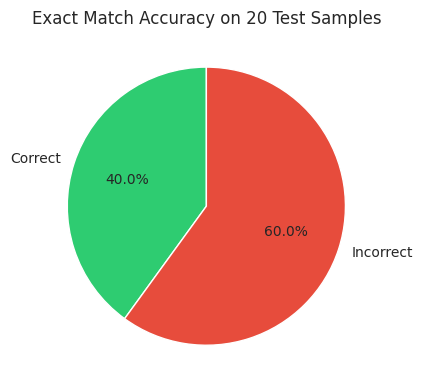

In [75]:
# Calculate accuracy metrics
exact_matches = sum(1 for r in results if r['exact_match'])
accuracy = exact_matches / len(results) * 100

print(f"Exact Match Accuracy: {exact_matches}/{len(results)} = {accuracy:.1f}%")

# Visualize accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie([exact_matches, len(results) - exact_matches], 
       labels=['Correct', 'Incorrect'], 
       colors=['#2ecc71', '#e74c3c'],
       autopct='%1.1f%%',
       startangle=90)
ax.set_title(f'Exact Match Accuracy on {len(results)} Test Samples')
plt.tight_layout()
plt.show()


In [76]:
# Calculate Character Error Rate (CER)
def calculate_cer(predicted, target):
    """Calculate Character Error Rate using Levenshtein distance"""
    if len(target) == 0:
        return 1.0 if len(predicted) > 0 else 0.0
    
    # Simple Levenshtein distance
    m, n = len(predicted), len(target)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if predicted[i-1] == target[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1
    
    return dp[m][n] / len(target)

cer_scores = [calculate_cer(r['predicted'], r['correct']) for r in results]
avg_cer = np.mean(cer_scores)

print(f"Character Error Rate (CER): {avg_cer:.4f} ({avg_cer * 100:.2f}%)")
print(f"Lower is better (0 = perfect)")


Character Error Rate (CER): 0.0501 (5.01%)
Lower is better (0 = perfect)


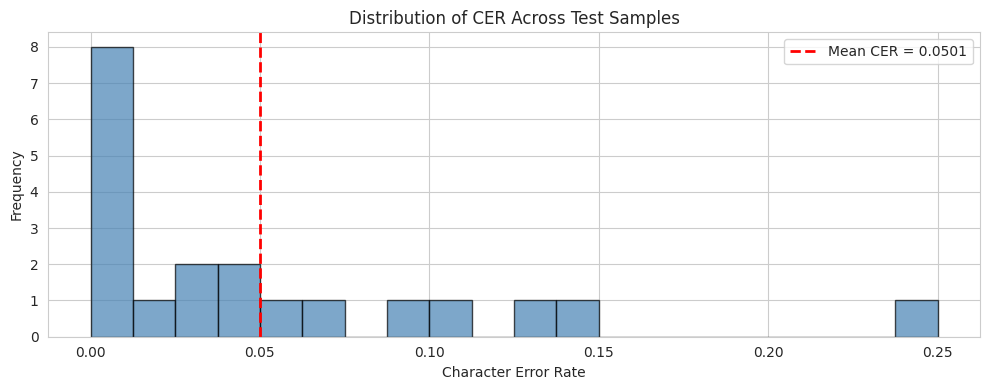

In [77]:
# Visualize CER distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(cer_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(x=avg_cer, color='red', linestyle='--', linewidth=2, label=f'Mean CER = {avg_cer:.4f}')
ax.set_xlabel('Character Error Rate')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of CER Across Test Samples')
ax.legend()
plt.tight_layout()
plt.show()


In [78]:
# Show detailed results table
results_df = pd.DataFrame(results)
results_df['cer'] = cer_scores
results_df['status'] = results_df['exact_match'].apply(lambda x: '✅' if x else '❌')

print("Detailed Test Results (first 10):")
print(results_df[['input', 'predicted', 'correct', 'status', 'cer']].head(10).to_string(index=False))


Detailed Test Results (first 10):
                                                      input                                                   predicted                                                     correct status      cer
              project looks to muelsnig ngeetic alternative               project looks to mulesing genetic alternative               project looks to mulesing genetic alternative      ✅ 0.000000
 chemical agents used during LrotWst at port ahgusra prixoj chemical agents used during protest at port angustra prixon  chemical agents used during protest at port augusta prison      ❌ 0.051724
         business hcmaber seeks budget infrastrcutuer boost          business chamber seeks budget infrastructure boost          business chamber seeks budget infrastructure boost      ✅ 0.000000
                3600 trips made to adrwni tip after cyconle                 3600 trips made to darwin tip after cyclone                 3600 trips made to darwin tip after cyclone   

---

### TF-IDF Analysis (Bonus)

TF-IDF (Term Frequency-Inverse Document Frequency) is a traditional NLP technique. While our spell checker uses deep learning (Seq2Seq with Attention), we can use TF-IDF to:

1. Analyze text similarity between input and output
2. Visualize word importance
3. Compare with our deep learning approach


In [79]:
# TF-IDF Analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("=" * 60)
print("TF-IDF ANALYSIS")
print("=" * 60)

# Create TF-IDF vectorizer (word-level)
tfidf_word = TfidfVectorizer(analyzer='word', max_features=1000)

# Create TF-IDF vectorizer (character n-gram level - more similar to our model)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=1000)

# Fit on training data
all_texts = train_input_texts[:1000] + [t.strip() for t in train_target_texts[:1000]]
tfidf_word.fit(all_texts)
tfidf_char.fit(all_texts)

print("✅ TF-IDF Vectorizers created:")
print(f"   Word-level: {len(tfidf_word.get_feature_names_out())} features")
print(f"   Char n-gram: {len(tfidf_char.get_feature_names_out())} features")


TF-IDF ANALYSIS
✅ TF-IDF Vectorizers created:
   Word-level: 1000 features
   Char n-gram: 1000 features


In [80]:
# Compare TF-IDF similarity: Input vs Predicted vs Correct
print("\nTF-IDF Similarity Analysis on Test Samples:")
print("-" * 60)

tfidf_results = []

for i, r in enumerate(results[:10]):  # First 10 test samples
    input_text = r['input']
    predicted_text = r['predicted']
    correct_text = r['correct']
    
    # Word-level TF-IDF similarity
    try:
        vectors_word = tfidf_word.transform([input_text, predicted_text, correct_text])
        sim_input_pred_word = cosine_similarity(vectors_word[0:1], vectors_word[1:2])[0][0]
        sim_input_correct_word = cosine_similarity(vectors_word[0:1], vectors_word[2:3])[0][0]
        sim_pred_correct_word = cosine_similarity(vectors_word[1:2], vectors_word[2:3])[0][0]
    except:
        sim_input_pred_word = sim_input_correct_word = sim_pred_correct_word = 0
    
    # Character n-gram TF-IDF similarity
    vectors_char = tfidf_char.transform([input_text, predicted_text, correct_text])
    sim_input_pred_char = cosine_similarity(vectors_char[0:1], vectors_char[1:2])[0][0]
    sim_pred_correct_char = cosine_similarity(vectors_char[1:2], vectors_char[2:3])[0][0]
    
    tfidf_results.append({
        'sample': i,
        'input_pred_word': sim_input_pred_word,
        'pred_correct_word': sim_pred_correct_word,
        'input_pred_char': sim_input_pred_char,
        'pred_correct_char': sim_pred_correct_char,
        'exact_match': r['exact_match']
    })
    
    print(f"Sample {i+1}:")
    print(f"  Input: {input_text[:40]}...")
    print(f"  Pred:  {predicted_text[:40]}...")
    print(f"  Similarity (Pred↔Correct): Word={sim_pred_correct_word:.3f}, Char={sim_pred_correct_char:.3f}")
    print()



TF-IDF Similarity Analysis on Test Samples:
------------------------------------------------------------
Sample 1:
  Input: project looks to muelsnig ngeetic altern...
  Pred:  project looks to mulesing genetic altern...
  Similarity (Pred↔Correct): Word=1.000, Char=1.000

Sample 2:
  Input: chemical agents used during LrotWst at p...
  Pred:  chemical agents used during protest at p...
  Similarity (Pred↔Correct): Word=0.837, Char=0.908

Sample 3:
  Input: business hcmaber seeks budget infrastrcu...
  Pred:  business chamber seeks budget infrastruc...
  Similarity (Pred↔Correct): Word=1.000, Char=1.000

Sample 4:
  Input: 3600 trips made to adrwni tip after cyco...
  Pred:  3600 trips made to darwin tip after cycl...
  Similarity (Pred↔Correct): Word=1.000, Char=1.000

Sample 5:
  Input: go net3een brisye to lprn july 5...
  Pred:  go netren briste to porn july 5...
  Similarity (Pred↔Correct): Word=0.592, Char=0.568

Sample 6:
  Input: whitsNundaygs Xbr%aces for schoolies inf...
  P

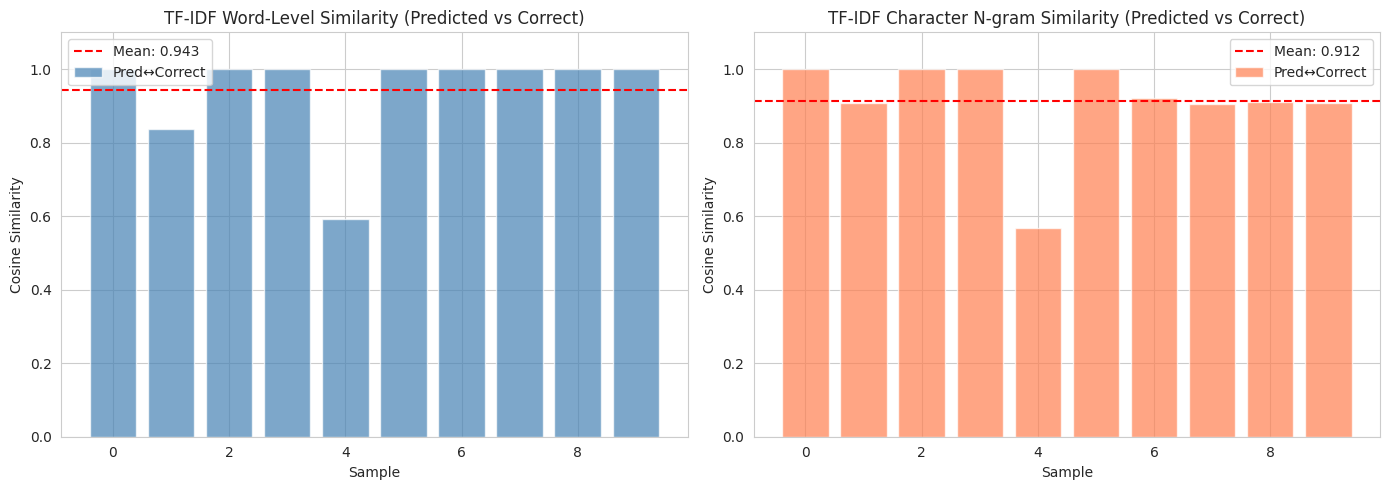


TF-IDF Similarity Summary:
  Word-level (Pred↔Correct):  Mean = 0.943
  Char n-gram (Pred↔Correct): Mean = 0.912

  Higher similarity = better prediction quality


In [81]:
# Visualize TF-IDF Similarity Results
tfidf_df = pd.DataFrame(tfidf_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Word-level similarity
axes[0].bar(range(len(tfidf_df)), tfidf_df['pred_correct_word'], color='steelblue', alpha=0.7, label='Pred↔Correct')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Cosine Similarity')
axes[0].set_title('TF-IDF Word-Level Similarity (Predicted vs Correct)')
axes[0].axhline(y=tfidf_df['pred_correct_word'].mean(), color='red', linestyle='--', label=f'Mean: {tfidf_df["pred_correct_word"].mean():.3f}')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Character n-gram similarity
axes[1].bar(range(len(tfidf_df)), tfidf_df['pred_correct_char'], color='coral', alpha=0.7, label='Pred↔Correct')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('TF-IDF Character N-gram Similarity (Predicted vs Correct)')
axes[1].axhline(y=tfidf_df['pred_correct_char'].mean(), color='red', linestyle='--', label=f'Mean: {tfidf_df["pred_correct_char"].mean():.3f}')
axes[1].legend()
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"\nTF-IDF Similarity Summary:")
print(f"  Word-level (Pred↔Correct):  Mean = {tfidf_df['pred_correct_word'].mean():.3f}")
print(f"  Char n-gram (Pred↔Correct): Mean = {tfidf_df['pred_correct_char'].mean():.3f}")
print(f"\n  Higher similarity = better prediction quality")


In [82]:
# Compare: Deep Learning (Seq2Seq) vs TF-IDF Approach
print("=" * 60)
print("COMPARISON: Deep Learning vs TF-IDF")
print("=" * 60)

print("""
┌─────────────────────────────────────────────────────────────┐
│              DEEP LEARNING (Your Model)                     │
├─────────────────────────────────────────────────────────────┤
│ ✅ Can GENERATE new corrected text                          │
│ ✅ Handles character insertions/deletions                   │
│ ✅ Learns complex patterns                                  │
│ ✅ Context-aware (attention mechanism)                      │
│ ❌ Requires more training data                              │
│ ❌ Slower inference                                         │
│ ❌ More computational resources                             │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│              TF-IDF APPROACH                                │
├─────────────────────────────────────────────────────────────┤
│ ✅ Fast to compute                                          │
│ ✅ Good for measuring similarity                            │
│ ✅ Works with small datasets                                │
│ ✅ Interpretable features                                   │
│ ❌ Cannot GENERATE new text                                 │
│ ❌ Only compares to known correct words                     │
│ ❌ Limited for spell correction (needs dictionary)          │
└─────────────────────────────────────────────────────────────┘

CONCLUSION:
  - TF-IDF: Good for ANALYSIS and SIMILARITY measurement
  - Seq2Seq: Good for GENERATION and CORRECTION
  
  Your notebook uses Seq2Seq (the right choice for spell checking!)
  TF-IDF is added here only for analysis purposes.
""")


COMPARISON: Deep Learning vs TF-IDF

┌─────────────────────────────────────────────────────────────┐
│              DEEP LEARNING (Your Model)                     │
├─────────────────────────────────────────────────────────────┤
│ ✅ Can GENERATE new corrected text                          │
│ ✅ Handles character insertions/deletions                   │
│ ✅ Learns complex patterns                                  │
│ ✅ Context-aware (attention mechanism)                      │
│ ❌ Requires more training data                              │
│ ❌ Slower inference                                         │
│ ❌ More computational resources                             │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│              TF-IDF APPROACH                                │
├─────────────────────────────────────────────────────────────┤
│ ✅ Fast to compute                                          │
│ ✅ Good f

Top TF-IDF Features (Word-level):
----------------------------------------
Top 20 words by average TF-IDF score:
  1. 'for': 0.0424
  2. 'to': 0.0382
  3. 'in': 0.0312
  4. 'of': 0.0283
  5. 'on': 0.0232
  6. 'the': 0.0183
  7. 'with': 0.0169
  8. 'police': 0.0166
  9. 'over': 0.0154
  10. 'after': 0.0139
  11. 'and': 0.0139
  12. 'man': 0.0107
  13. 'at': 0.0102
  14. 'as': 0.0095
  15. 'from': 0.0095
  16. 'by': 0.0094
  17. 'australian': 0.0090
  18. 'fire': 0.0083
  19. 'charged': 0.0083
  20. 'calls': 0.0075


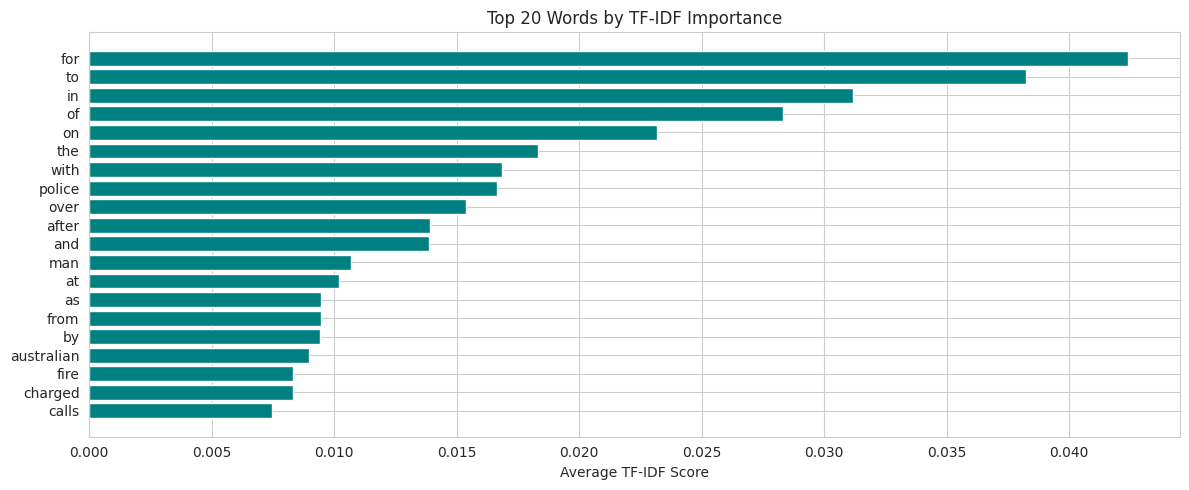

In [83]:
# Bonus: TF-IDF for Word Importance Visualization
print("Top TF-IDF Features (Word-level):")
print("-" * 40)

# Get feature names and their average TF-IDF scores
feature_names = tfidf_word.get_feature_names_out()
sample_texts = [t.strip() for t in train_target_texts[:500]]
tfidf_matrix = tfidf_word.transform(sample_texts)

# Calculate average TF-IDF score for each word
avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
top_indices = avg_tfidf.argsort()[-20:][::-1]

print("Top 20 words by average TF-IDF score:")
for i, idx in enumerate(top_indices):
    print(f"  {i+1}. '{feature_names[idx]}': {avg_tfidf[idx]:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
top_words = [feature_names[i] for i in top_indices]
top_scores = [avg_tfidf[i] for i in top_indices]
ax.barh(top_words[::-1], top_scores[::-1], color='teal')
ax.set_xlabel('Average TF-IDF Score')
ax.set_title('Top 20 Words by TF-IDF Importance')
plt.tight_layout()
plt.show()


---

### Final Metrics Summary


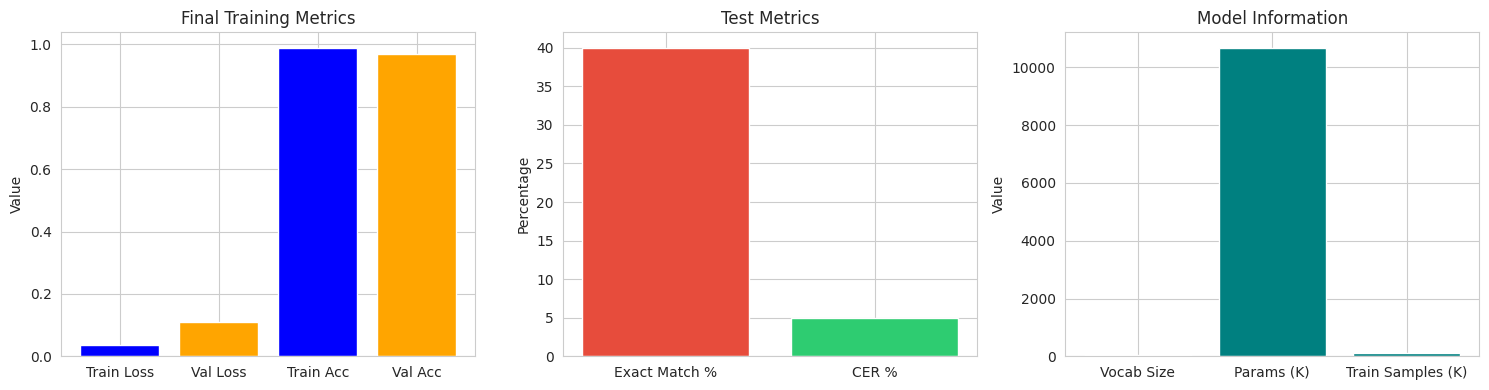


TRAINING COMPLETE - SUMMARY
Model saved to: best_speller_pro.h5
Tokenizer saved to: tokenizer.pickle
Test Exact Match: 40.0%
Test CER: 5.01%


In [84]:
import matplotlib.pyplot as plt

acc_key = 'acc' if 'acc' in history.history else 'accuracy'
val_acc_key = 'val_acc' if 'val_acc' in history.history else 'val_accuracy'

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train_metrics = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
train_values = [
    history.history['loss'][-1], 
    history.history['val_loss'][-1],
    history.history[acc_key][-1], 
    history.history[val_acc_key][-1]
]
axes[0].bar(train_metrics, train_values, color=['blue', 'orange', 'blue', 'orange'])
axes[0].set_title('Final Training Metrics')
axes[0].set_ylabel('Value')


final_acc = accuracy if 'accuracy' in locals() else 0
final_cer = avg_cer if 'avg_cer' in locals() else 0

test_metrics = ['Exact Match %', 'CER %']
test_values = [final_acc, final_cer * 100]
colors = ['#2ecc71' if final_acc > 50 else '#e74c3c', 
          '#2ecc71' if final_cer < 0.1 else '#e74c3c']
axes[1].bar(test_metrics, test_values, color=colors)
axes[1].set_title('Test Metrics')
axes[1].set_ylabel('Percentage')


params_count = model.count_params() if 'model' in locals() else 0
samples_count = len(train_input_texts) if 'train_input_texts' in locals() else 100000

info_labels = ['Vocab Size', 'Params (K)', 'Train Samples (K)']
info_values = [vocab_size, params_count/1000, samples_count/1000]
axes[2].bar(info_labels, info_values, color='teal')
axes[2].set_title('Model Information')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"Model saved to: best_speller_pro.h5")
print(f"Tokenizer saved to: tokenizer.pickle")
print(f"Test Exact Match: {final_acc:.1f}%")
print(f"Test CER: {final_cer*100:.2f}%")
print("="*60)


---

## Save Tokenizer


In [85]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ tokenizer.pickle saved!")
print("\nYou can now run app.py to start the web server.")


✅ tokenizer.pickle saved!

You can now run app.py to start the web server.


---
---


---

## Sequence Length Analysis: Why Lower MAX_SEQ_LEN Hurts Performance

This section explains why using a **lower MAX_SEQ_LEN** results in worse model performance.


In [86]:
# ============================================================
# ANALYSIS: Why Lower MAX_SEQ_LEN Causes Worse Performance
# ============================================================

print("=" * 70)
print("🔍 SEQUENCE LENGTH ANALYSIS: Why Lower Values Hurt Performance")
print("=" * 70)

# Calculate how many samples are affected by different MAX_SEQ_LEN values
input_lengths = [len(txt) for txt in train_input_texts]
target_lengths = [len(txt) for txt in train_target_texts]

# Test different MAX_SEQ_LEN values
test_seq_lens = [40, 60, 80, 100, 120, 150]

print("\n📊 PROBLEM 1: TRUNCATION - Data Loss at Different MAX_SEQ_LEN Values")
print("-" * 70)
print(f"{'MAX_SEQ_LEN':<15} {'Inputs Truncated':<20} {'Targets Truncated':<20} {'Data Lost %':<15}")
print("-" * 70)

truncation_data = []
for seq_len in test_seq_lens:
    inputs_truncated = sum(1 for l in input_lengths if l > seq_len)
    targets_truncated = sum(1 for l in target_lengths if l > seq_len)
    data_lost_pct = (inputs_truncated / len(input_lengths)) * 100
    
    truncation_data.append({
        'seq_len': seq_len,
        'inputs_truncated': inputs_truncated,
        'targets_truncated': targets_truncated,
        'data_lost_pct': data_lost_pct
    })
    
    print(f"{seq_len:<15} {inputs_truncated:<20} {targets_truncated:<20} {data_lost_pct:.2f}%")

print("\n⚠️ TRUNCATION PROBLEM:")
print("   When MAX_SEQ_LEN is too low, the END of sentences gets CUT OFF!")
print("   Example: 'The quick brown fox jumps over the lazy dog'")
print("   With MAX_SEQ_LEN=20: 'The quick brown fox ' → INFORMATION LOST!")


🔍 SEQUENCE LENGTH ANALYSIS: Why Lower Values Hurt Performance

📊 PROBLEM 1: TRUNCATION - Data Loss at Different MAX_SEQ_LEN Values
----------------------------------------------------------------------
MAX_SEQ_LEN     Inputs Truncated     Targets Truncated    Data Lost %    
----------------------------------------------------------------------
40              65413                72228                65.41%
60              6915                 9631                 6.92%
80              0                    0                    0.00%
100             0                    0                    0.00%
120             0                    0                    0.00%
150             0                    0                    0.00%

⚠️ TRUNCATION PROBLEM:
   When MAX_SEQ_LEN is too low, the END of sentences gets CUT OFF!
   Example: 'The quick brown fox jumps over the lazy dog'
   With MAX_SEQ_LEN=20: 'The quick brown fox ' → INFORMATION LOST!


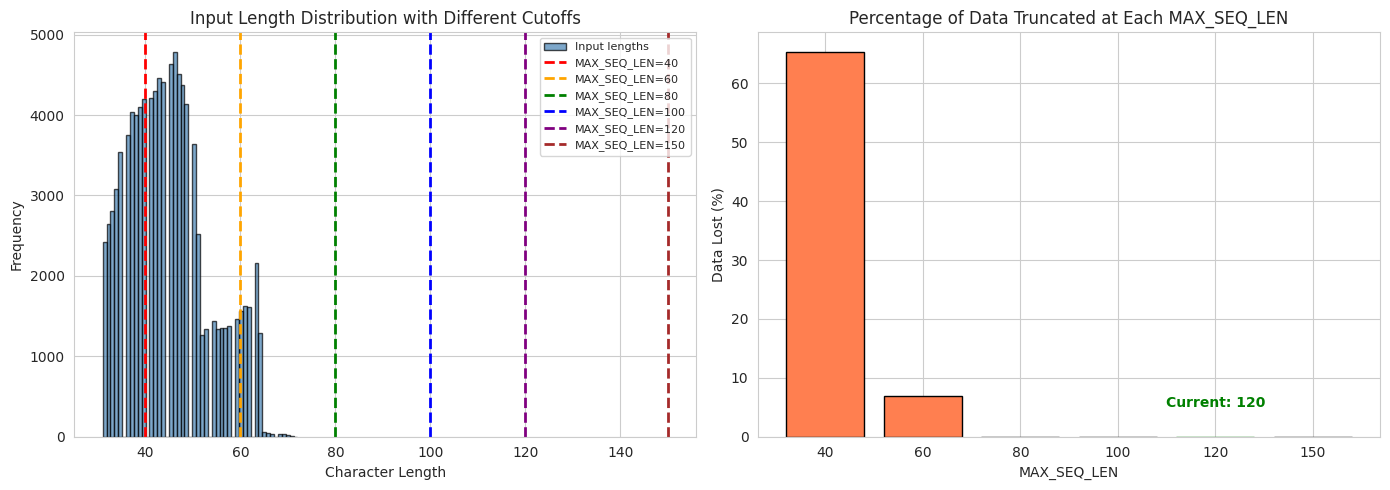


✅ Current MAX_SEQ_LEN = 120
   Data being truncated: 0 samples (0.00%)


In [87]:
# Visualize Truncation Impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram with different cutoff lines
axes[0].hist(input_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7, label='Input lengths')
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown']
for i, seq_len in enumerate(test_seq_lens):
    axes[0].axvline(x=seq_len, color=colors[i], linestyle='--', linewidth=2, 
                    label=f'MAX_SEQ_LEN={seq_len}')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Input Length Distribution with Different Cutoffs')
axes[0].legend(fontsize=8)

# Right: Bar chart of data lost
seq_lens = [d['seq_len'] for d in truncation_data]
data_lost = [d['data_lost_pct'] for d in truncation_data]
bars = axes[1].bar(range(len(seq_lens)), data_lost, color='coral', edgecolor='black')
axes[1].set_xticks(range(len(seq_lens)))
axes[1].set_xticklabels(seq_lens)
axes[1].set_xlabel('MAX_SEQ_LEN')
axes[1].set_ylabel('Data Lost (%)')
axes[1].set_title('Percentage of Data Truncated at Each MAX_SEQ_LEN')

# Highlight current setting
current_idx = seq_lens.index(MAX_SEQ_LEN) if MAX_SEQ_LEN in seq_lens else -1
if current_idx >= 0:
    bars[current_idx].set_color('green')
    axes[1].annotate(f'Current: {MAX_SEQ_LEN}', xy=(current_idx, data_lost[current_idx]), 
                     xytext=(current_idx, data_lost[current_idx] + 5),
                     ha='center', fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Current MAX_SEQ_LEN = {MAX_SEQ_LEN}")
print(f"   Data being truncated: {sum(1 for l in input_lengths if l > MAX_SEQ_LEN)} samples ({sum(1 for l in input_lengths if l > MAX_SEQ_LEN)/len(input_lengths)*100:.2f}%)")



📊 PERFORMANCE ANALYSIS BY INPUT LENGTH

Length Bucket   Total Samples   Correct         Accuracy %     
------------------------------------------------------------
21-40           3               0               0.00%
41-60           17              8               47.06%


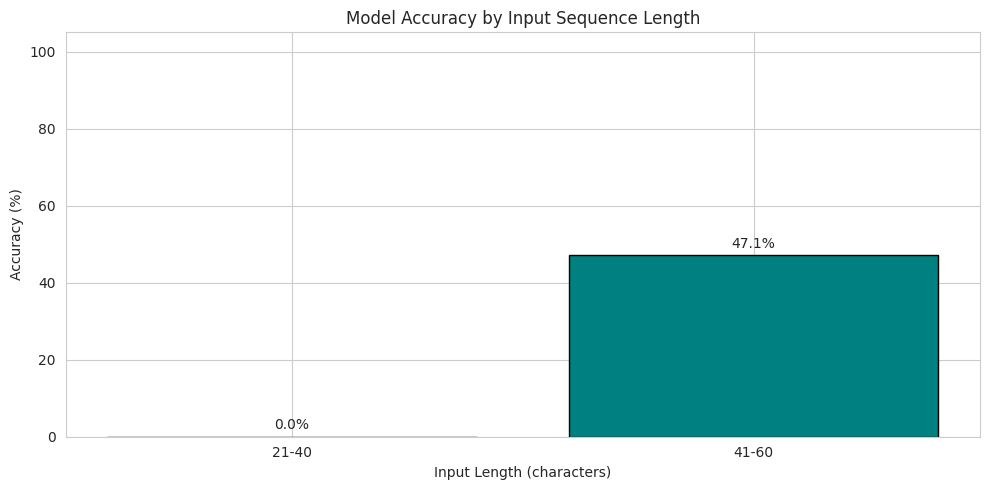

In [90]:
# ============================================================
# ANALYZE PERFORMANCE BY SEQUENCE LENGTH
# ============================================================

print("\n" + "=" * 70)
print("📊 PERFORMANCE ANALYSIS BY INPUT LENGTH")
print("=" * 70)

# Group test results by input length (if results exist)
try:
    if 'results' in dir() and len(results) > 0:
        # Create length buckets
        def get_length_bucket(length):
            if length <= 20:
                return '1-20'
            elif length <= 40:
                return '21-40'
            elif length <= 60:
                return '41-60'
            elif length <= 80:
                return '61-80'
            else:
                return '80+'
        
        # Analyze each bucket
        length_performance = {}
        for r in results:
            bucket = get_length_bucket(len(r['input']))
            if bucket not in length_performance:
                length_performance[bucket] = {'total': 0, 'correct': 0}
            length_performance[bucket]['total'] += 1
            if r['exact_match']:
                length_performance[bucket]['correct'] += 1
        
        print(f"\n{'Length Bucket':<15} {'Total Samples':<15} {'Correct':<15} {'Accuracy %':<15}")
        print("-" * 60)
        
        bucket_data = []
        for bucket in ['1-20', '21-40', '41-60', '61-80', '80+']:
            if bucket in length_performance:
                data = length_performance[bucket]
                accuracy = (data['correct'] / data['total'] * 100) if data['total'] > 0 else 0
                bucket_data.append({'bucket': bucket, 'accuracy': accuracy, 'total': data['total']})
                print(f"{bucket:<15} {data['total']:<15} {data['correct']:<15} {accuracy:.2f}%")
        
        # Visualize
        if len(bucket_data) > 1:
            fig, ax = plt.subplots(figsize=(10, 5))
            buckets = [d['bucket'] for d in bucket_data]
            accuracies = [d['accuracy'] for d in bucket_data]
            bars = ax.bar(buckets, accuracies, color='teal', edgecolor='black')
            ax.set_xlabel('Input Length (characters)')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title('Model Accuracy by Input Sequence Length')
            ax.set_ylim(0, 105)
            
            # Add value labels
            for bar, acc in zip(bars, accuracies):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                       f'{acc:.1f}%', ha='center', fontsize=10)
            
            plt.tight_layout()
            plt.show()
    else:
        print("⚠️ No test results available. Run the test cell first to see performance by length.")
except Exception as e:
    print(f"⚠️ Could not analyze results: {e}")
    print("   Run the test/evaluation cells first to generate 'results' variable.")
